<a href="https://colab.research.google.com/github/dominikklepl/Neural-Networks-Intracranial-hemorrhage-detection/blob/master/05_Multilayer%20perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP with PCA and t-SNE
This will be the last method that we apply in this project. Compared to the other methods it is extremely simply and therefore provide fast training and inference and might provide reasonably simple interpretability.

We'll feed the pixel values to PCA to reduce the dimensionality to 50, normalize them to mean=0 and sd=1. Finally we'll train a multilinear perceptron using the PCA features as input.

In [0]:
prototyping = False

## Setup and paths to data

Install missing packages

In [0]:
!pip install pydicom

     |████████████████████████████████| 7.1MB 5.5MB/s 


Import all required packages

In [0]:
#connect google drive
from google.colab import drive

#dealing with zip
import zipfile

#importing labels and working with dataframe
import pandas as pd

#manipulation with images
#import pydicom
import torch
import numpy as np
from math import ceil, floor, log
import cv2

#train-test
from sklearn.model_selection import GroupKFold

#models
from sklearn.neural_network import MLPClassifier

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


1.15.0


In [0]:
#ignore deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

Check that GPU is available and that keras can use it.

In [0]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

Set random seed for reproducibility

In [0]:
np.random.seed(31415)

Connect Google Drive. That's where my data is stored.

In [0]:
GDRIVE_PATH = "/gdrive"
drive.mount(GDRIVE_PATH)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


Set paths to all required data

In [0]:
WORK_DIR = "/content/"
BASE_DIR = GDRIVE_PATH + "/My Drive/"
ZIP_PATH = BASE_DIR + "DICOMS/train_images.zip"
DF_PATH = BASE_DIR + "train_balanced.csv"
IMAGES_PATH = WORK_DIR + "img"
FIG_PATH = BASE_DIR + "plots"

#if the model and results aren't created already, create them
!mkdir /gdrive/My\ Drive/models
!mkdir /gdrive/My\ Drive/results
!mkdir /gdrive/My\ Drive/plots

#also create temporary folder in working directory for unzipping images
!mkdir /content/img

mkdir: cannot create directory ‘/gdrive/My Drive/models’: File exists
mkdir: cannot create directory ‘/gdrive/My Drive/results’: File exists
mkdir: cannot create directory ‘/content/img’: File exists


In [0]:
#get number of CPU cores
import multiprocessing
CORES = multiprocessing.cpu_count()
print(CORES)

4


Images are saved in a zip file. For easier and faster manipulation, let's extract them to a folder in the working directory that we created before ("/content/img")

In [0]:
img_archive = zipfile.ZipFile(ZIP_PATH)
%time img_archive.extractall(path=IMAGES_PATH)

CPU times: user 13min 54s, sys: 2min 22s, total: 16min 16s
Wall time: 19min 24s


### Load the csv with labels and metadata

In [0]:
train_df = pd.read_csv(DF_PATH)
train_df.sample(3)

,Unnamed: 0,Unnamed: 0.1,index,SOPInstanceUID,Modality,PatientID,StudyInstanceUID,SeriesInstanceUID,StudyID,ImagePositionPatient,ImageOrientationPatient,SamplesPerPixel,PhotometricInterpretation,Rows,Columns,PixelSpacing,BitsAllocated,BitsStored,HighBit,PixelRepresentation,WindowCenter,WindowWidth,RescaleIntercept,RescaleSlope,fname,MultiImagePositionPatient,ImagePositionPatient1,ImagePositionPatient2,MultiImageOrientationPatient,ImageOrientationPatient1,ImageOrientationPatient2,ImageOrientationPatient3,ImageOrientationPatient4,ImageOrientationPatient5,MultiPixelSpacing,PixelSpacing1,img_min,img_max,img_mean,img_std,img_pct_window,MultiWindowCenter,WindowCenter1,MultiWindowWidth,WindowWidth1,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,pct_cut,split
139665,139665,139665,312002,ID_779858c27,CT,ID_2ecaabfe,ID_7107642e03,ID_04b1318e8e,NaN,-125.0,1.0,1,MONOCHROME2,512,512,0.488281,16,16,15,1,30.0,80.0,-1024.0,1.0,../input/rsna-intracranial-hemorrhage-detectio...,1,-116.640732,156.931549,1,0.0,0.0,0.0,0.965926,-0.258819,1,0.488281,-2000,2806,-68.513100,1163.294980,0.125107,NaN,NaN,NaN,NaN,0,0,0,0,0,0,"(0.1, 0.2]",14
148871,148871,148871,427720,ID_e96c9e3db,CT,ID_7173bbfa,ID_60d1f23a4a,ID_f8da691279,NaN,-125.0,1.0,1,MONOCHROME2,512,512,0.488281,16,16,15,1,30.0,80.0,-1024.0,1.0,../input/rsna-intracranial-hemorrhage-detectio...,1,-121.289818,132.876526,1,0.0,0.0,0.0,0.945519,-0.325568,1,0.488281,-2000,2815,69.768433,1220.667199,0.245369,NaN,NaN,NaN,NaN,0,0,0,0,0,0,"(0.2, 0.3]",15
40455,40455,40455,281098,ID_194db803f,CT,ID_77de44ad,ID_d621130e3d,ID_b555440e84,NaN,-123.0,1.0,1,MONOCHROME2,512,512,0.488281,16,12,11,0,40.0,80.0,-1024.0,1.0,../input/rsna-intracranial-hemorrhage-detectio...,1,-50.001010,180.051520,1,0.0,0.0,0.0,0.978148,-0.207912,1,0.488281,0,2610,491.905163,580.444349,0.304535,1.0,40.0,1.0,80.0,1,0,0,0,0,1,"(0.3, 1.0]",5


Some of the columns are useless at this point, let's keep just those that we actually need. Also some of the columns have too long name, yes SOPInstanceUID I'm talking about you so we'll rename them.

In [0]:
train = train_df[['SOPInstanceUID',
                  'PatientID',
                  'any',
                  'epidural',
                  'intraparenchymal',
                  'intraventricular',
                  'subarachnoid',
                  'subdural']].copy()
train.rename(columns={'SOPInstanceUID': 'ID',
                      'PatientID': 'Patient'},
              inplace=True)

In [0]:
if prototyping:
  train = train.sample(200)
  train = train.reset_index(drop=True)

In [0]:
train.head(5)

,ID,Patient,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
3804,ID_071852ae9,ID_907b01cd,1,0,0,0,1,0
51053,ID_2ec274695,ID_33e26eaf,1,0,0,1,0,0
102426,ID_692f3dfb6,ID_f380901e,0,0,0,0,0,0
153411,ID_862a087e3,ID_acd4a315,0,0,0,0,0,0
167291,ID_2f642523e,ID_0df59147,0,0,0,0,0,0


In [0]:
len(train)

9704

### Load bins for uniform transform

In [0]:
bins = torch.load(BASE_DIR+"bins.pt").numpy()

## Data processing functions
Before we can start building awesome neural networks, we need a few helper functions for constructing data (i.e. images) in form that's acceptable for the models to learn from.

First, functions for reading DICOM and applying intercept and slope.

In [0]:
#correcting dcm with wrong meta-data (explained in preprocessing notebook)
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

#transform dicom to HU by applying intercept and slope
def rescale_dcm(dcm):
  if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
    correct_dcm(dcm)
  return dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept

### Use full scale but apply uniform distribution

In [0]:
def to_full(dcm, bins):
  ys = np.linspace(0., 1., len(bins))
  x = dcm.flatten()
  x = np.interp(x, bins, ys)
  x = x.reshape(dcm.shape).clip(0.,1.) * 2**16
  x = x.astype(np.uint16)
  x[x<np.median(x)]=0
  x = np.stack((x,)*3, axis=-1)
  return x

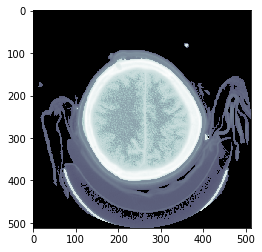

In [0]:
#test it
dcm = pydicom.dcmread(IMAGES_PATH+"/"+train.ID[0]+".dcm")
dcm = rescale_dcm(dcm)
x = to_full(dcm, bins)
plt.imshow(x[:,:,0], cmap=plt.cm.bone)

### Getting channels and save them as color channels

In [0]:
def window_image(img, window_center, window_width, U=1.0, eps=(1.0 / 255.0)):
    ue = np.log((U / eps) - 1.0)
    W = (2 / window_width) * ue
    b = ((-2 * window_center) / window_width) * ue
    z = W * img + b
    img = U / (1 + np.power(np.e, -1.0 * z))
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return img

def to_channels(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)
    return bsb_img

In [0]:
#Finally function for loading a single image and resizing it to the input size.
def read_img(ID, resize, preprocess):
    path = IMAGES_PATH+'/'+ID+'.dcm'
    dcm = pydicom.dcmread(path)
    dcm = rescale_dcm(dcm)

    if preprocess is "CH":
      try: img = to_channels(dcm)
      except: img = np.zeros(resize)
    if preprocess is "F":
      try: img = to_full(dcm, bins)
      except: img = np.zeros(resize)

    img = cv2.resize(img, resize[:2], interpolation=cv2.INTER_CUBIC) #resize
    img = (img - np.min(img))/(np.max(img)-np.min(img)) #min-max normalize
    return img

CPU times: user 79.1 ms, sys: 7.84 ms, total: 86.9 ms
Wall time: 130 ms
CPU times: user 15.3 ms, sys: 1.87 ms, total: 17.1 ms
Wall time: 24.6 ms
(250, 250, 3)


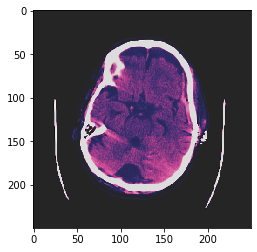

In [0]:
%time img_ch = read_img(train.ID[2], (250, 250, 3), preprocess="CH")
%time img_f = read_img(train.ID[2], (250, 250, 3), preprocess="F")

#some sanity checks
plt.imshow(img_ch)
print(img_ch.shape)

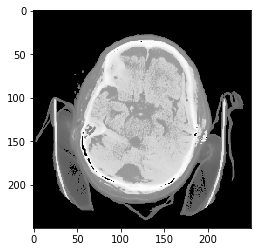

In [0]:
plt.imshow(img_f)

### Data generator
This function prepares each batch for feeding to neural network. First, it gets random IDs and associated labels. Then shuffles them, to reduce bias. Finally, the images, using the IDs are loaded using the _read function defined above.

The function is generalized for both training and testing data.

It is derived from keras.sequence so it should be enabled for multiprocessing.

#### Full-preprocessing DataGenerator

In [0]:
class DataGenerator_Full(keras.utils.Sequence):

    def __init__(self, IDs, labels=None, batch_size=30, img_size=(299, 299, 3), num_classes=5, *args, **kwargs):
        self.IDs = IDs
        self.labels = labels.loc[:, 'any':'subdural']
        self.batch_size = batch_size
        self.img_size = img_size
        self.num_classes = num_classes
        self.on_epoch_end()

#define number of steps per epoch
    def __len__(self):
        return int(ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        #indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        IDs_batch = self.IDs[index*self.batch_size:(index+1)*self.batch_size]
        if self.labels is not None:
          X, y_any, y_subtype = self.__data_generation(IDs_batch)
          return X, [y_any, y_subtype]
        else:
            X = self.__data_generation(IDs_batch)
            return X
        
    def on_epoch_end(self):
      self.indices = np.arange(len(self.IDs))

    def __data_generation(self, IDs_batch):
        X = np.empty((self.batch_size, *self.img_size))
        if self.labels is not None: # training
          y_subtype = np.empty((self.batch_size, self.num_classes))
          y_any = np.empty((self.batch_size, 1))
          for i, ID in enumerate(IDs_batch):
            X[i,] = read_img(ID, self.img_size, preprocess="F")
            y_any[i], y_subtype[i] = self.__get_target(ID)
          return X, y_any, y_subtype
        else: # testing
            for i, ID in enumerate(IDs_batch):
                X[i,] = read_img(ID, self.img_size, preprocess="F")
            return X

    def __get_target(self, ID):
        y_any = self.labels.loc[ID, "any"]
        y_subtype = self.labels.drop("any", axis=1).loc[ID].values
        return y_any, y_subtype

#### Channels-preprocessing DataGenerator

In [0]:
class DataGenerator_Channels(keras.utils.Sequence):

    def __init__(self, IDs, labels=None, batch_size=30, img_size=(299, 299, 3), num_classes=5, *args, **kwargs):
        self.IDs = IDs
        self.labels = labels.loc[:, 'any':'subdural']
        self.batch_size = batch_size
        self.img_size = img_size
        self.num_classes = num_classes
        self.on_epoch_end()

#define number of steps per epoch
    def __len__(self):
        return int(ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        IDs_batch = self.IDs[index*self.batch_size:(index+1)*self.batch_size]
        if self.labels is not None:
          X, y_any, y_subtype = self.__data_generation(IDs_batch)
          return X, [y_any, y_subtype]
        else:
            X = self.__data_generation(IDs_batch)
            return X
        
    def on_epoch_end(self):
      self.indices = np.arange(len(self.IDs))

    def __data_generation(self, IDs_batch):
        X = np.empty((self.batch_size, *self.img_size))
        if self.labels is not None: # training
          y_subtype = np.empty((self.batch_size, self.num_classes))
          y_any = np.empty((self.batch_size, 1))
          for i, ID in enumerate(IDs_batch):
            X[i,] = read_img(ID, self.img_size, preprocess="CH")
            y_any[i], y_subtype[i] = self.__get_target(ID)
          return X, y_any, y_subtype
        else: # testing
          for i, ID in enumerate(IDs_batch):
            X[i,] = read_img(ID, self.img_size, preprocess="CH")
          return X

    def __get_target(self, ID):
        y_any = self.labels.loc[ID, "any"]
        y_subtype = self.labels.drop("any", axis=1).loc[ID].values
        return y_any, y_subtype

## Train-test split
We'll save 10% of images for testing.

In [0]:
group_kfold = GroupKFold(n_splits=10)

for tr, ts in group_kfold.split(train, groups=train.Patient):
  training = train.iloc[tr]
  testing = train.iloc[ts]

testing = testing.set_index('ID', drop=False)
print(training.shape)
print(testing.shape)

(17468, 8)
(1940, 8)


### Train-validation split

In [0]:
tr_val_folds = GroupKFold(n_splits=20)

for tr, ts in tr_val_folds.split(training, groups=training.Patient):
  train_data = training.iloc[tr]
  val_data = training.iloc[ts]

train_data = train_data.set_index('ID', drop=False)
val_data = val_data.set_index('ID', drop=False)
print(train_data.shape)
print(val_data.shape)

(16595, 8)
(873, 8)


### Data generators

In [0]:
train_dataloader_CH = DataGenerator_Channels(IDs=train_data.ID,
                                 labels=train_data.loc[:,'any':'subdural'],
                                 batch_size=len(train_data),
                                 img_size=(135,135,3),
                                 num_classes=5)
val_dataloader_CH = DataGenerator_Channels(IDs=val_data.ID,
                               labels=val_data.loc[:,'any':'subdural'],
                               batch_size=len(val_data),
                               img_size=(135,135,3),
                               num_classes=5)
test_dataloader_CH = DataGenerator_Channels(IDs=testing.ID,
                               labels=testing.loc[:,'any':'subdural'],
                               batch_size=len(testing),
                               img_size=(135,135,3),
                               num_classes=5)

train_dataloader_F = DataGenerator_Full(IDs=train_data.ID,
                                 labels=train_data.loc[:,'any':'subdural'],
                                 batch_size=len(train_data),
                                 img_size=(135,135,3),
                                 num_classes=5)
val_dataloader_F = DataGenerator_Full(IDs=val_data.ID,
                               labels=val_data.loc[:,'any':'subdural'],
                               batch_size=len(val_data),
                               img_size=(135,135,3),
                               num_classes=5)
test_dataloader_F = DataGenerator_Full(IDs=testing.ID,
                               labels=testing.loc[:,'any':'subdural'],
                               batch_size=len(testing),
                               img_size=(135,135,3),
                               num_classes=5)

## Channel feature extraction

In [0]:
#load all images and their labels
X_tr_CH, [_, _] = train_dataloader_CH.__getitem__(0)
X_v_CH, [y1_v_CH, y2_v_CH] = val_dataloader_CH.__getitem__(0)
X_ts_CH, [y1_ts_CH, y2_ts_CH] = test_dataloader_CH.__getitem__(0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in power
  


In [0]:
#sanity check
print(X_tr_CH.shape)

(16595, 135, 135, 3)


## Data normalization

In [0]:
#move these to the rest of imports later
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

In [0]:
scaler = StandardScaler()
X_tr_CH = scaler.fit_transform([i.flatten() for i in X_tr_CH])
X_v_CH = scaler.transform([i.flatten() for i in X_v_CH])
X_ts_CH = scaler.transform([i.flatten() for i in X_ts_CH])

## PCA feature extraction

In [0]:
pca = PCA(n_components=50)
X_tr_CH = pca.fit_transform(X_tr_CH)
X_v_CH = pca.transform(X_v_CH)
X_ts_CH = pca.transform(X_ts_CH)

## t-SNE for visualisation
t-SNE can project features from high-dimensional space (in this case our PCA components) to low dimensional space (2 or 3D) so that we can plot the results to inspect if the features form some clusters labels.

In [0]:
tsne = TSNE(n_components=2, perplexity=40.0)
tsne_tr_CH = tsne.fit_transform(X_tr_CH)
tsne_v_CH = tsne.fit_transform(X_v_CH)
tsne_ts_CH = tsne.fit_transform(X_ts_CH)
tsne_scaler = StandardScaler()
tsne_tr_CH = tsne_scaler.fit_transform(tsne_tr_CH)
tsne_v_CH = tsne_scaler.transform(tsne_v_CH)
tsne_ts_CH = tsne_scaler.transform(tsne_ts_CH)

Save PCA features and t-SNE represantion to csv

In [0]:
labels_tr = train_data.loc[:,'any':'subdural']
labels_val = val_data.loc[:,'any':'subdural']
labels_ts = testing.loc[:, 'any':'subdural']

labels_tr['set']="train"
labels_val['set']="val"
labels_ts['set']="test"

labels = pd.concat([labels_tr, labels_val, labels_ts],axis=0)
labels.to_csv(BASE_DIR+'labels.csv')

In [0]:
X_tr_CH = pd.DataFrame(data=X_tr_CH)
X_v_CH = pd.DataFrame(data=X_v_CH)
X_ts_CH = pd.DataFrame(data=X_ts_CH)
X_tr_CH.to_csv(BASE_DIR + "train_pca_CH.csv")
X_v_CH.to_csv(BASE_DIR + "val_pca_CH.csv")
X_ts_CH.to_csv(BASE_DIR + "test_pca_CH.csv")

tsne_tr_CH = pd.DataFrame(data=tsne_tr_CH)
tsne_v_CH = pd.DataFrame(data=tsne_v_CH)
tsne_ts_CH = pd.DataFrame(data=tsne_ts_CH)
tsne_tr_CH.to_csv(BASE_DIR + "train_tsne_CH.csv")
tsne_v_CH.to_csv(BASE_DIR + "val_tsne_CH.csv")
tsne_ts_CH.to_csv(BASE_DIR + "test_tsne_CH.csv")

## Full feature extraction

In [0]:
#load all images and their labels
X_tr_F, [y1_tr_F, y2_tr_F] = train_dataloader_F.__getitem__(0)
X_v_F, [y1_v_F, y2_v_F] = val_dataloader_F.__getitem__(0)
X_ts_F, [y1_ts_F, y2_ts_F] = test_dataloader_F.__getitem__(0)
scaler = StandardScaler()
X_tr_F = scaler.fit_transform([i.flatten() for i in X_tr_F])
X_v_F = scaler.transform([i.flatten() for i in X_v_F])
X_ts_F = scaler.transform([i.flatten() for i in X_ts_F])
pca = PCA(n_components=50)
X_tr_F = pca.fit_transform(X_tr_F)
X_v_F = pca.transform(X_v_F)
X_ts_F = pca.transform(X_ts_F)
tsne = TSNE(n_components=2, perplexity=40.0)
tsne_tr_F = tsne.fit_transform(X_tr_F)
tsne_v_F = tsne.fit_transform(X_v_F)
tsne_ts_F = tsne.fit_transform(X_ts_F)
tsne_scaler = StandardScaler()
tsne_tr_F = tsne_scaler.fit_transform(tsne_tr_F)
tsne_v_F = tsne_scaler.transform(tsne_v_F)
tsne_ts_F = tsne_scaler.transform(tsne_ts_F)
X_tr_F = pd.DataFrame(data=X_tr_F)
X_v_F = pd.DataFrame(data=X_v_F)
X_ts_F = pd.DataFrame(data=X_ts_F)
X_tr_F.to_csv(BASE_DIR + "train_pca_F.csv")
X_v_F.to_csv(BASE_DIR + "val_pca_F.csv")
X_ts_F.to_csv(BASE_DIR + "test_pca_F.csv")
tsne_tr_F = pd.DataFrame(data=tsne_tr_F)
tsne_v_F = pd.DataFrame(data=tsne_v_F)
tsne_ts_F = pd.DataFrame(data=tsne_ts_F)
tsne_tr_F.to_csv(BASE_DIR + "train_tsne_F.csv")
tsne_v_F.to_csv(BASE_DIR + "val_tsne_F.csv")
tsne_ts_F.to_csv(BASE_DIR + "test_tsne_F.csv")

## Load data
After running PCA and t-SNE we cleaned the memory. So we need to reload the data

In [0]:
X_train = pd.read_csv(BASE_DIR + "train_pca_CH.csv", index_col=0)
X_val = pd.read_csv(BASE_DIR + "val_pca_CH.csv", index_col=0)
X_test = pd.read_csv(BASE_DIR + "test_pca_CH.csv", index_col=0)

y = pd.read_csv(BASE_DIR + "labels.csv")
y_train = y.loc[y.set=="train",:].drop(["set"],axis=1)
y_val = y.loc[y.set=="val",:].drop(["set"],axis=1)
y_test = y.loc[y.set=="test",:].drop(["set"],axis=1)
X_train = pd.concat([X_train, X_val], axis=0)
y_train = pd.concat([y_train, y_val], axis=0)

In [0]:
y_train.head(5)

,ID,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_a2c9f4b53,1,0,0,0,0,1
1,ID_026337b1a,1,0,0,0,0,1
2,ID_8137a8650,0,0,0,0,0,0
3,ID_cfe5c292f,0,0,0,0,0,0
4,ID_ab0df9757,1,0,0,1,0,0


## Build MLP

### Channels

In [0]:
MLP1 = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=(50,), validation_fraction=0.1, early_stopping=True)
MLP2 = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=(50,40,), validation_fraction=0.1, early_stopping=True)
MLP3 = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=(50,40,25), validation_fraction=0.1, early_stopping=True)
MLP4 = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=(50,40,25,12), validation_fraction=0.1, early_stopping=True)
MLP5 = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=(50,40,25,12,1), validation_fraction=0.1, early_stopping=True)

MLP1_ch = MLP1.fit(X=X_train, y=y_train.loc[:,'any':'subdural'])
MLP2_ch = MLP2.fit(X=X_train, y=y_train.loc[:,'any':'subdural'])
MLP3_ch = MLP3.fit(X=X_train, y=y_train.loc[:,'any':'subdural'])
MLP4_ch = MLP4.fit(X=X_train, y=y_train.loc[:,'any':'subdural'])
MLP5_ch = MLP5.fit(X=X_train, y=y_train.loc[:,'any':'subdural'])

In [0]:
from sklearn.metrics import f1_score, roc_curve, precision_score, recall_score, roc_auc_score

In [0]:
print(f1_score(y_true = y_test.loc[:,'any':'subdural'],y_pred = MLP1_ch.predict(X=X_test), average='weighted'))
print(f1_score(y_true = y_test.loc[:,'any':'subdural'],y_pred = MLP2_ch.predict(X=X_test), average='weighted'))
print(f1_score(y_true = y_test.loc[:,'any':'subdural'],y_pred = MLP3_ch.predict(X=X_test), average='weighted'))
print(f1_score(y_true = y_test.loc[:,'any':'subdural'],y_pred = MLP4_ch.predict(X=X_test), average='weighted'))
print(f1_score(y_true = y_test.loc[:,'any':'subdural'],y_pred = MLP5_ch.predict(X=X_test), average='weighted'))

0.37252487207335244
0.36091026926800623
0.31561406190998714
0.2708371733422125
0.39670522113858936


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


MLP1 is the best one, plot ROC curve

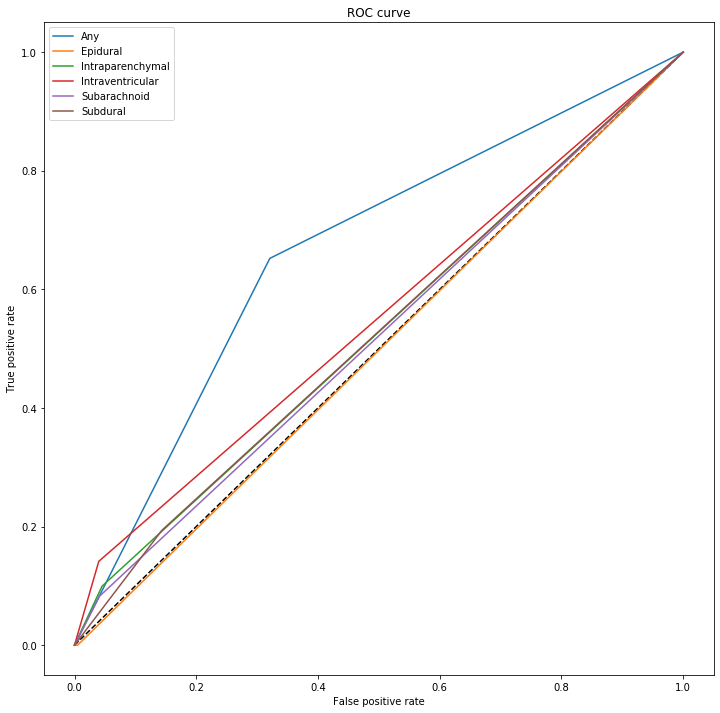

<Figure size 432x288 with 0 Axes>

In [0]:
y_pred = MLP1_ch.predict(X=X_test)
fpr_any, tpr_any, _ = roc_curve(y_test['any'], y_pred[:,0])
fpr_ep, tpr_ep, _ = roc_curve(y_test['epidural'], y_pred[:,1])
fpr_ip, tpr_ip, _ = roc_curve(y_test['intraparenchymal'], y_pred[:,2])
fpr_iv, tpr_iv, _ = roc_curve(y_test['intraventricular'], y_pred[:,3])
fpr_sa, tpr_sa, _ = roc_curve(y_test['subarachnoid'], y_pred[:,4])
fpr_sd, tpr_sd, _ = roc_curve(y_test['subdural'], y_pred[:,5])


plt.figure(num=1, figsize=(12,12))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_any, tpr_any, label="Any")
plt.plot(fpr_ep, tpr_ep, label="Epidural")
plt.plot(fpr_ip, tpr_ip, label="Intraparenchymal")
plt.plot(fpr_iv, tpr_iv, label="Intraventricular")
plt.plot(fpr_sa, tpr_sa, label="Subarachnoid")
plt.plot(fpr_sd, tpr_sd, label="Subdural")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Function for printing all metrics for single label

In [0]:
def print_score(i, label):
  print("\nLabel: {}" .format(label))
  print("Accuracy: %8.3f %%" %(accuracy_score(y_test[label], y_pred[:,i])*100))
  print("Precision: %8.3f %%" %(precision_score(y_test[label], y_pred[:,i])*100))
  print("Recall: %8.3f %%" %(recall_score(y_test[label], y_pred[:,i])*100))
  print("Area under ROC curve: %8.3f" %(roc_auc_score(y_test[label], y_pred[:,i])))

In [0]:
I = list(np.arange(0,6))
labs = ["any", "epidural", "intraparenchymal", "intraventricular", "subarachnoid", "subdural"]

for i, l in zip(I,labs):
  print_score(i,l)

with open(BASE_DIR + 'MLP_CH_performance.txt', 'w') as f:
    with redirect_stdout(f):
      for i, l in zip(I,labs):
        print_score(i,l)


Label: any
Accuracy:   66.701 %
Precision:   62.500 %
Recall:   65.217 %
Area under ROC curve:    0.666

Label: epidural
Accuracy:   98.557 %
Precision:    0.000 %
Recall:    0.000 %
Area under ROC curve:    0.497

Label: intraparenchymal
Accuracy:   82.165 %
Precision:   28.846 %
Recall:    9.934 %
Area under ROC curve:    0.527

Label: intraventricular
Accuracy:   88.247 %
Precision:   27.083 %
Recall:   14.130 %
Area under ROC curve:    0.551

Label: subarachnoid
Accuracy:   84.948 %
Precision:   22.222 %
Recall:    8.264 %
Area under ROC curve:    0.521

Label: subdural
Accuracy:   70.825 %
Precision:   28.000 %
Recall:   19.355 %
Area under ROC curve:    0.525


### Full

In [0]:
X_train = pd.read_csv(BASE_DIR + "train_pca_F.csv", index_col=0)
X_val = pd.read_csv(BASE_DIR + "val_pca_F.csv", index_col=0)
X_test = pd.read_csv(BASE_DIR + "test_pca_F.csv", index_col=0)

y = pd.read_csv(BASE_DIR + "labels.csv")
y_train = y.loc[y.set=="train",:].drop(["set"],axis=1)
y_val = y.loc[y.set=="val",:].drop(["set"],axis=1)
y_test = y.loc[y.set=="test",:].drop(["set"],axis=1)
X_train = pd.concat([X_train, X_val], axis=0)
y_train = pd.concat([y_train, y_val], axis=0)

In [0]:
MLP1 = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=(50,), validation_fraction=0.1, early_stopping=True)
MLP2 = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=(50,40,), validation_fraction=0.1, early_stopping=True)
MLP3 = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=(50,40,25), validation_fraction=0.1, early_stopping=True)
MLP4 = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=(50,40,25,12), validation_fraction=0.1, early_stopping=True)
MLP5 = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=(50,40,25,12,1), validation_fraction=0.1, early_stopping=True)

MLP1_f = MLP1.fit(X=X_train, y=y_train.loc[:,'any':'subdural'])
MLP2_f = MLP2.fit(X=X_train, y=y_train.loc[:,'any':'subdural'])
MLP3_f = MLP3.fit(X=X_train, y=y_train.loc[:,'any':'subdural'])
MLP4_f = MLP4.fit(X=X_train, y=y_train.loc[:,'any':'subdural'])
MLP5_f = MLP5.fit(X=X_train, y=y_train.loc[:,'any':'subdural'])

MLP1 is the best

In [0]:
print(f1_score(y_true = y_test.loc[:,'any':'subdural'],y_pred = MLP1_f.predict(X=X_test), average='weighted'))
print(f1_score(y_true = y_test.loc[:,'any':'subdural'],y_pred = MLP2_f.predict(X=X_test), average='weighted'))
print(f1_score(y_true = y_test.loc[:,'any':'subdural'],y_pred = MLP3_f.predict(X=X_test), average='weighted'))
print(f1_score(y_true = y_test.loc[:,'any':'subdural'],y_pred = MLP4_f.predict(X=X_test), average='weighted'))
print(f1_score(y_true = y_test.loc[:,'any':'subdural'],y_pred = MLP5_f.predict(X=X_test), average='weighted'))

0.38909803764662415
0.3621812662759878
0.3229191288244508
0.2997881063362996
0.11693071534380824


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


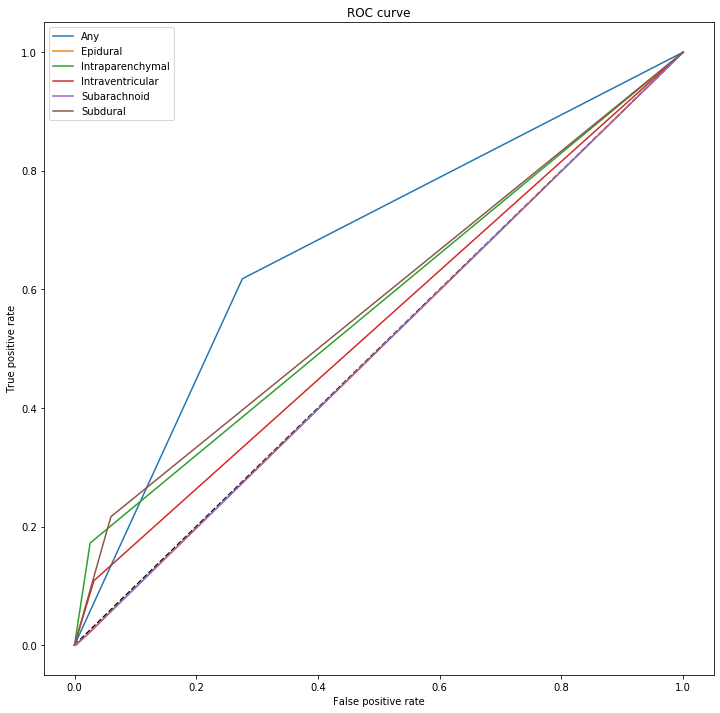

In [0]:
y_pred = MLP1_f.predict(X=X_test)
fpr_any, tpr_any, _ = roc_curve(y_test['any'], y_pred[:,0])
fpr_ep, tpr_ep, _ = roc_curve(y_test['epidural'], y_pred[:,1])
fpr_ip, tpr_ip, _ = roc_curve(y_test['intraparenchymal'], y_pred[:,2])
fpr_iv, tpr_iv, _ = roc_curve(y_test['intraventricular'], y_pred[:,3])
fpr_sa, tpr_sa, _ = roc_curve(y_test['subarachnoid'], y_pred[:,4])
fpr_sd, tpr_sd, _ = roc_curve(y_test['subdural'], y_pred[:,5])


plt.figure(num=1, figsize=(12,12))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_any, tpr_any, label="Any")
plt.plot(fpr_ep, tpr_ep, label="Epidural")
plt.plot(fpr_ip, tpr_ip, label="Intraparenchymal")
plt.plot(fpr_iv, tpr_iv, label="Intraventricular")
plt.plot(fpr_sa, tpr_sa, label="Subarachnoid")
plt.plot(fpr_sd, tpr_sd, label="Subdural")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [0]:
for i, l in zip(I,labs):
  print_score(i,l)

with open(BASE_DIR + 'MLP_F_performance.txt', 'w') as f:
    with redirect_stdout(f):
      for i, l in zip(I,labs):
        print_score(i,l)


Label: any
Accuracy:   67.629 %
Precision:   64.748 %
Recall:   61.785 %
Area under ROC curve:    0.671

Label: epidural
Accuracy:   98.763 %
Precision:    0.000 %
Recall:    0.000 %
Area under ROC curve:    0.498

Label: intraparenchymal
Accuracy:   84.948 %
Precision:   55.319 %
Recall:   17.219 %
Area under ROC curve:    0.573

Label: intraventricular
Accuracy:   88.660 %
Precision:   26.316 %
Recall:   10.870 %
Area under ROC curve:    0.538

Label: subarachnoid
Accuracy:   85.979 %
Precision:   10.526 %
Recall:    1.653 %
Area under ROC curve:    0.498

Label: subdural
Accuracy:   77.835 %
Precision:   51.087 %
Recall:   21.659 %
Area under ROC curve:    0.578
